In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

# from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
pheme = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv').Event

ext = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')

# Torch

## BERTCLF 노트북을 참고한 방법 - Train -> LSTM으로 바꿔보기

In [313]:
train_inputs = torch.tensor(pheme.values).float()
val_inputs = torch.tensor(ext.values).float()

# Convert other data types to torch.Tensor
train_labels = torch.tensor(pheme_y.values).float()
val_labels = torch.tensor(ext_y.values).float()

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [314]:
print("Length of the Inputs are:\nTrain\t%s\nVal\t%s" %(train_inputs.size(), val_inputs.size()))

Length of the Inputs are:
Train	torch.Size([5802, 200])
Val	torch.Size([485, 200])


In [352]:
import random

class AvgW2VNet(torch.nn.Module):
  def __init__(self, freeze_model=False):
    """
    In the constructor we construct three nn.Linear instances that we will use
    in the forward pass.
    """
    super(AvgW2VNet, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size

    D_in, H, D_out = 200, 16, 1

    self.rnn = nn.LSTM(
        input_size = input_size, 
        hidden_size = hidden_size, 
        num_layers = 4, 
        batch_first = True,
        bidirectional = True
    )

    self.layers = nn.Sequential(
        nn.ReLU(),
        nn.Linear(input_size*2, hidden_size),
    )

    # self.classifier = nn.Sequential(
    #     nn.Linear(D_in, H),
    #     nn.BatchNorm1d(H),
    #     nn.ReLU(),
    #     nn.Dropout(0.2),
    #     nn.Linear(H, D_out),
    #     nn.Sigmoid()
    # )

  def forward(self, x):
    y,_ = self.rnn(x)
    result = self.layers(y)
    return result

In [353]:
# from torch.nn.optim import Adam

def initialize_model(epochs=300):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    model = AvgW2VNet()

    # Tell PyTorch to run the model on GPU
    model.to(device)

    # Create the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.1)

    criterion = nn.BCELoss()
    # loss = nn.CrossEntropyLoss()

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    # scheduler = get_linear_schedule_with_warmup(optimizer,
    #                                             num_warmup_steps=0, # Default value
    #                                             num_training_steps=total_steps)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=0.1, gamma= 0.99)       

    return model, optimizer, criterion, scheduler
    # return bert_classifier, optimizer, scheduler


In [354]:
import random
import time


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    val_loss_list = []
    val_acc_list = []
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        # print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input)

            # Compute loss and accumulate the loss values
            # torch.argmax(logits(i)) for logit, i in enumerate(logits)
            
            # print(torch.argmax(logits))
            # print(logits)
            # print(b_labels.type())
            # print(torch.argmax(logits, dim=1))
            logits = logits.flatten()
            loss = criterion(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                # print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_accuracy)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            # print(val_loss_list)
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    # print(val_loss_list)
    # print(np.range(1,epochs+1))
    fig = plt.figure(figsize=(18,10))
    plt.plot(np.arange(0,epochs),val_loss_list)
    fig2 = plt.figure(figsize=(18,10))
    plt.plot(np.arange(0,epochs),val_acc_list)
    print("Training complete!")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input)
            # print(logits)
            # logits = logits.flatten()

        # Compute loss
        loss = criterion(logits.flatten(), b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        # print(logits)
        # print(torch.argmax(logits), dim=1)
        # print(logits)
        # print(torch.argmax(logits, dim=1))
        preds = torch.argmax(logits, dim=1)

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        # print(preds)
        # print(b_labels)
        # print((preds == b_labels))
        # print((preds == b_labels).numpy().mean())
        # print(accuracy)
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [355]:
set_seed(42)    # Set seed for reproducibility
model, optimizer, criterion, scheduler = initialize_model(epochs=100)
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    -    |   0.639528   |  0.610964  |   25.60   |   0.53   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    -    |   0.647421   |  0.771703  |   25.60   |   0.48   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    -    |   0.647474   |  0.784059  |   25.60   |   0.48   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-----------------------------------------------------------

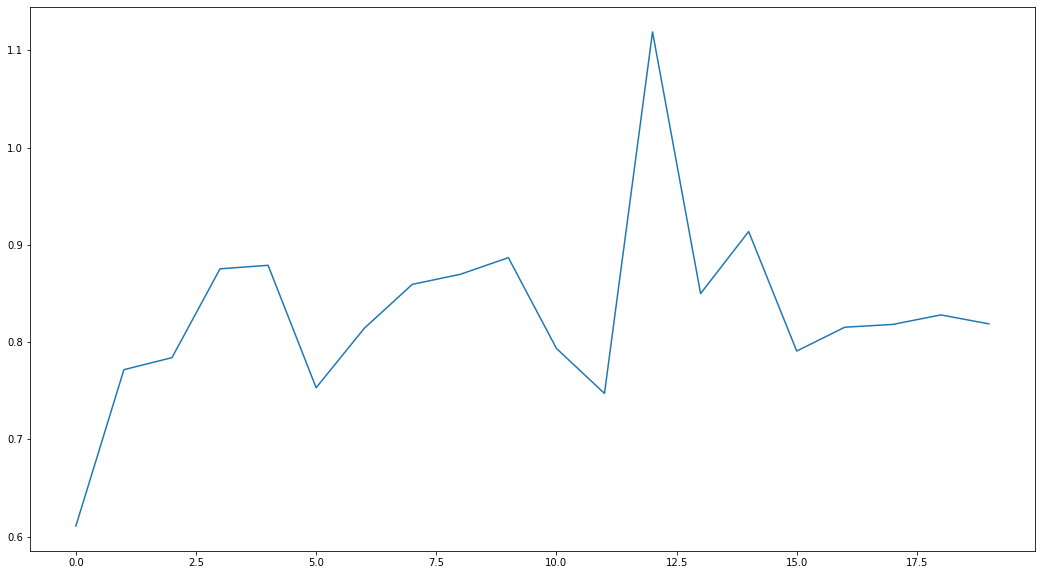

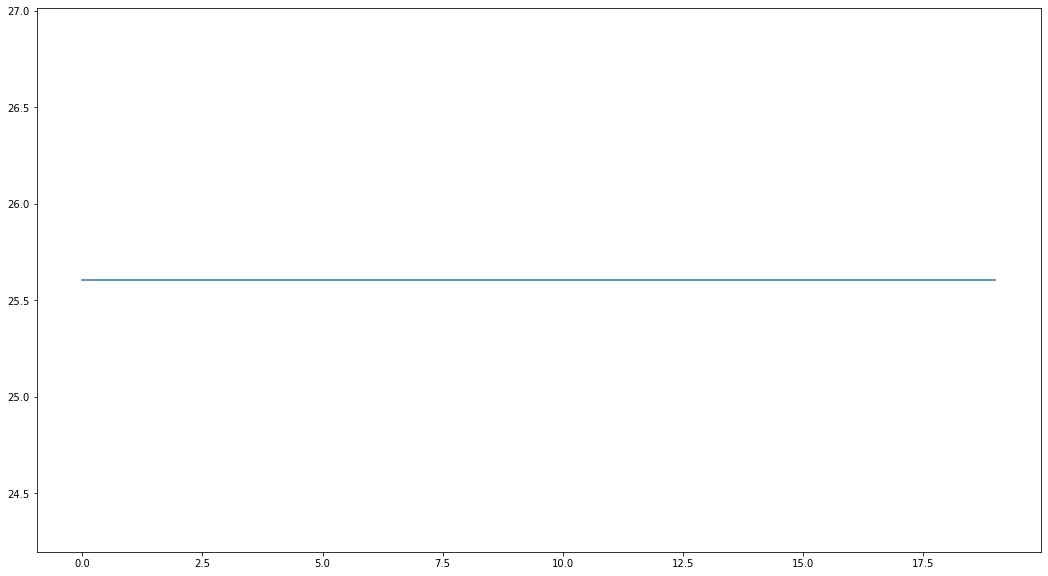

In [356]:
train(model, train_dataloader, val_dataloader, epochs=20, evaluation=True)

## Test

In [370]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [388]:
import torch.nn.functional as F

def model_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input,b_labels = tuple(t.to(device) for t in batch)
        # print(b_input)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu()

    return probs

In [425]:
# Compute predicted probabilities on the test set
probs = model_predict(model, val_dataloader)
probs = probs.numpy()
# print(probs)
# print(type(probs))

# # Evaluate the Bert classifier
# print(len(probs))
target = torch.tensor(ext_y)
target = target.unsqueeze(dim=1).numpy()
# print(target)
evaluate_roc(probs, target)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
model.eval()
correct = 0
total = 0
test_loss = 0
outputs_list = []
y_list = []

with torch.no_grad():
    val_loss = 0

    for i, data in enumerate(test_loader):
        x, y = data
        x, y = x.float(), y.long()
        outputs = task1_model(x)
        loss = criterion(outputs, y.unsqueeze(1).float())
        _, predicted = torch.max(outputs.data, 1)
        outputs_list.append(predicted[:])
        total += y.size(0)
        correct += (predicted == y).double().sum().item()
        val_loss += loss.item()
        y_list.append(y)

print('Accuracy of the test dataset is: %d %%' % (100 * correct / total))
print("Loss of validation set: {:.5f}".format((val_loss / test_size)))
acc = (100 * correct / total)

## adf

In [ ]:
task1_model.eval()
correct = 0
total = 0
test_loss = 0
outputs_list = []
y_list = []

with torch.no_grad():
    val_loss = 0

    for i, data in enumerate(task1_test_dataloader):
        x, y = data
        x, y = x.float(), y.long()
        outputs = task1_model(x)
        loss = criterion(outputs, y.unsqueeze(1).float())
        _, predicted = torch.max(outputs.data, 1)
        outputs_list.append(predicted[:])
        total += y.size(0)
        correct += (predicted == y).double().sum().item()
        val_loss += loss.item()
        y_list.append(y)

print('Accuracy of the test dataset is: %d %%' % (100 * correct / total))
print("Loss of validation set: {:.5f}".format((val_loss / test_size)))
acc = (100 * correct / total)

In [39]:
print(task1_model.parameters)

<bound method Module.parameters of FC_net(
  (fc1): Linear(in_features=792, out_features=130, bias=True)
  (fc2): Linear(in_features=130, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=1, bias=True)
  (drop_2): Dropout(p=0.2, inplace=False)
)>


In [40]:
import torch.optim as optim

criterion = nn.BCELoss()
# optimizer = optim.SGD(task1_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(task1_model.parameters(), lr=0.01)

In [41]:
train_loss = []
train_accuracy = []

prev_loss = 10
PATH = "./state_dict_BERT_fc.pt"
best_acc = 10.0
num_epochs = 10

val_corrects_list = []
val_loss_list = []

In [42]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_loss = 0.0
    running_corrects = 0
    task1_model.train()  # Set model to training mode
    for i, data in enumerate(task1_train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs, labels = inputs.float(), labels.long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = task1_model(inputs)

        labels = labels.unsqueeze(1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()    

        running_loss += loss.item()
        running_corrects += torch.sum(outputs == labels.data)
        # print(running_corrects)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)

    print('Train) Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    # if epoch_loss < best_acc:
    #     # print("prev_loss: {:.5f}".format(prev_loss))
    #     # print("loss: {:.5f}".format(loss))
    #     print("Saving the best model w/ loss {:.4f}".format(epoch_loss))
    #     torch.save(task1_model.state_dict(),PATH)
    #     best_acc = epoch_loss

Epoch 0/9
----------
Train) Loss: 0.3190 Acc: 0.0042
Epoch 1/9
----------
Train) Loss: 5.4705 Acc: 0.6325
Epoch 2/9
----------
Train) Loss: 5.7149 Acc: 0.6568
Epoch 3/9
----------
Train) Loss: 5.7213 Acc: 0.6568
Epoch 4/9
----------
Train) Loss: 5.7149 Acc: 0.6568
Epoch 5/9
----------
Train) Loss: 5.7213 Acc: 0.6568
Epoch 6/9
----------
Train) Loss: 5.7149 Acc: 0.6568
Epoch 7/9
----------
Train) Loss: 5.7149 Acc: 0.6568
Epoch 8/9
----------
Train) Loss: 5.7213 Acc: 0.6568
Epoch 9/9
----------
Train) Loss: 5.7213 Acc: 0.6568


In [43]:
task1_model.eval()
correct = 0
total = 0
test_loss = 0
outputs_list = []
y_list = []

with torch.no_grad():
    val_loss = 0

    for i, data in enumerate(task1_test_dataloader):
        x, y = data
        x, y = x.float(), y.long()
        outputs = task1_model(x)
        loss = criterion(outputs, y.unsqueeze(1).float())
        _, predicted = torch.max(outputs.data, 1)
        outputs_list.append(predicted[:])
        total += y.size(0)
        correct += (predicted == y).double().sum().item()
        val_loss += loss.item()
        y_list.append(y)

print('Accuracy of the test dataset is: %d %%' % (100 * correct / total))
print("Loss of validation set: {:.5f}".format((val_loss / test_size)))
acc = (100 * correct / total)

Accuracy of the test dataset is: 68 %
Loss of validation set: 5.20883


# LSTM

In [2]:
def pad_sents(sents, pad_token):
    """ Pad list of sentences to the longest length in the batch.
    @param sents (list[list[str]]): list of tokenized strings
    @param pad_token (int): pad token
    @returns sents_padded (list[list[int]]): list of tokenized sentences with padding shape: (batch_size, max_sentence_length)
    """
    sents_padded = []

    max_len = max(len(s) for s in sents)
    for s in sents:
        padded = [pad_token] * max_len
        padded[:len(s)] = s
        sents_padded.append(padded)
    return sents_padded

def sents_to_tensor(tokenizer, sents):
    """
    :param tokenizer
    :param sents: list[str], list of untokenized strings
    """
    tokens_list = [tokenizer.tokenize(sent) for sent in sents]
    sents_lengths = [len(tokens) for tokens in tokens_list]
    sents_lengths = torch.tensor(sents_lengths)
    
    tokens_list_padded = pad_sents(tokens_list, '[PAD]')
    masks = np.asarray(tokens_list_padded)!='[PAD]'
    masks_tensor = torch.tensor(masks, dtype=torch.long)
    tokens_id_list = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokens_list_padded]
    sents_tensor = torch.tensor(tokens_id_list, dtype=torch.long)

    return sents_tensor, masks_tensor, sents_lengths

In [ ]:
import torch.nn.utils
from torch.nn.utils.rnn import pack_padded_sequence
import sys
import pickle
from vocab import VocabEntry

class BaselineModel(nn.Module):
    def __init__(self, rnn_state_size, embedding, vocab, num_tweet_class, dropout_rate=0):
        """
        @param hidden_size (int): size of lstm hidden layer
        @param embedding (torch.Tensor): shape (num_of_words_in_dict, embed_dim), glove embedding matrix
        @param vocab (VocabEntry): GloVe word dictionary/index
        @param num_tweet_class (int): number of labels / classes
        @param dropout_rate (float): dropout rate for training
        """

        super(BaselineModel, self).__init__()
        self.rnn_state_size = rnn_state_size
        # self.embed_dim = embedding.size(1)
        # self.vocab = vocab
        self.num_tweet_class = num_tweet_class
        self.padding_idx = self.vocab['<pad>']
        self.dropout_rate = dropout_rate
        self.embedding_layer = nn.Embedding.from_pretrained(embeddings = embedding, 
                                                            freeze=True, # freeze weights from training
                                                            padding_idx=self.padding_idx, 
                                                            max_norm=None, 
                                                            norm_type=2.0, 
                                                            scale_grad_by_freq=False, 
                                                            sparse=False)
        # Create a embedding using GloVE pretrained weights
        self.lstm = nn.LSTM(input_size = self.embed_dim, 
                            hidden_size = self.rnn_state_size, 
                            num_layers = 1, 
                            bias = True, 
                            batch_first = False, 
                            dropout = 0, 
                            bidirectional = True #use a bi-directional LSTM
                           )
        self.affine = nn.Linear(in_features = 2*self.rnn_state_size, #the hidden stats of the biLSTM is stacked
                                out_features = self.num_tweet_class, 
                                bias=True)
        # fully connected layer before softmax
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self, sents):
        """
        @param sents (list[list[str]]): a list of a list of words, sorted in descending length
        @return output (torch.Tensor): logits to put into softmax function to calculate prob
        """
        text_lengths = torch.tensor([len(sent) for sent in sents])
        sents_tensor = self.vocab.to_input_tensor(sents)  # Convert from list to tensor (max_sent_length, batch_size)
        x_embed = self.embedding_layer(sents_tensor)  # create embedding for words (max_sent_length, batch_size, embed_size)
        seq = pack_padded_sequence(x_embed.float(), text_lengths)
        enc_hiddens, (last_hidden, last_cell) = self.lstm(seq)
        output_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1)  # (batch_size, 2*hidden_size)
        output_hidden = self.dropout(output_hidden)
        output = self.affine(output_hidden)  # (batch_size, n_class)

        return output

    @staticmethod
    def load(model_path: str):
        """ Load the model from a file.
        @param model_path (str): path to model
        @return model (nn.Module): model with saved parameters
        """
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = BaselineModel(vocab=params['vocab'], embedding=params['embedding'], **args)
        model.load_state_dict(params['state_dict'])

        return model​

    def save(self, path: str):
        """ Save the model to a file.
        @param path (str): path to the model
        """
        print('save model parameters to [%s]' % path, file=sys.stderr)

        params = {
            'args': dict(rnn_state_size=self.rnn_state_size,    
                         dropout_rate=self.dropout_rate,
                         num_tweet_class=self.num_tweet_class),
            'vocab': self.vocab,
            'embedding': self.embedding_layer.weight,
            'state_dict': self.state_dict()
        }
        torch.save(params, path)

In [ ]:
from pytorch_pretrained_bert import BertAdam
from bert import default_bert, LSTM_bert 
import pickle
import numpy as np
import torch
import pandas as pd
import time
import sys
from utils import batch_iter

def validation(model, df_val, loss_func, bert_size):
    """ validation of model during training.
    @param model (nn.Module): the model being trained
    @param df_val (dataframe): validation dataset, sorted in descending text length
    @param loss_func(nn.Module): loss function
    @return avg loss value across validation dataset
    """
    was_training = model.training
    model.eval() #model.eval() put all layers in model in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.

    df_val = df_val.sort_values(by='tweet_proc_BERT'+bert_size+'_length', ascending=False)
    
    tweet_proc_bert = list(df_val['tweet_proc_bert'])
    type_label = list(df_val['type_label'])

    val_batch_size = 32
    num_val_samples = df_val.shape[0]
    ​
    n_batch = int(np.ceil(num_val_samples/val_batch_size))

    total_loss = 0.
    
    with torch.no_grad():
        for i in range(n_batch):
            sents = tweet_proc_bert[i*val_batch_size: (i+1)*val_batch_size]
            targets = torch.tensor(type_label[i*val_batch_size: (i+1)*val_batch_size],
                                   dtype=torch.long)
            batch_size = len(sents)
            output = model(sents)
            batch_loss = loss_func(output, targets)
            total_loss += batch_loss.item()*batch_size

    if was_training:
        model.train()

    return total_loss/num_val_samples    

def train(args):
    
    label_name = ['not informative', 
            'other useful information', 
            'caution and advice',
            'affected individuals', 
            'infrastructure and utilities damage',
            'donations and volunteering',
            'sympathy and support',
            ]
    
    # save_file_name = args['--model']+'_model.bin'
    bert_size = args['--bert-config'].split('-')[1]
    
    start_time = time.time()
    print('Importing data...', file=sys.stderr)
    df_train = pd.read_csv(args['--train'], index_col=0)
    df_val = pd.read_csv(args['--dev'], index_col=0)
    train_label = dict(df_train['type_label'].value_counts())
    label_max = float(max(train_label.values()))
    print(train_label, file=sys.stderr)
    train_label_weight = torch.tensor([label_max/train_label[i] for i in range(len(train_label))])
    print('Done! time elapsed %.2f sec' % (time.time() - start_time), file=sys.stderr)
    print('-' * 80, file=sys.stderr)
    
    start_time = time.time()
    print('Set up model...', file=sys.stderr)
    
    if args['--model'] == 'default_bert':
        model = default_bert(num_class=len(label_name), bert_config=args['--bert-config'])
        optimizer_grouped_parameters = [
                {'params': model.model.bert.parameters()},
                {'params': model.model.classifier.parameters(), 'lr': float(args['--lr'])}
                ]
        optimizer = BertAdam(optimizer_grouped_parameters, 
                             lr=float(args['--lr-bert']),
                             max_grad_norm=float(args['--clip-grad'])
                             )
    elif args['--model'] == 'LSTM_bert':
        model = LSTM_bert(num_class=len(label_name), dropout_rate=float(args['--dropout']), bert_config=args['--bert-config'])
        optimizer_grouped_parameters = [
                {'params': model.bert.parameters()},
                {'params': model.lstm.parameters(), 'lr': float(args['--lr'])},
                {'params': model.fc.parameters(), 'lr': float(args['--lr'])}]
        optimizer = BertAdam(optimizer_grouped_parameters, 
                             lr=float(args['--lr-bert']),
                             max_grad_norm=float(args['--clip-grad'])
                             )
    else:
        print('wrong model...', file=sys.stderr)
            
        
    print('Done! time elapsed %.2f sec' % (time.time() - start_time), file=sys.stderr)
    print('-' * 80, file=sys.stderr)
    
    model.train() #set model for training mode
    criterion = torch.nn.CrossEntropyLoss(weight=train_label_weight, reduction='mean')
    torch.save(criterion, 'loss_func')  # for later testing

    train_batch_size = int(args['--batch-size'])
    valid_niter = int(args['--valid-niter'])
    display_num = int(args['--display_num'])
    model_save_path = args['--save-to']

    num_restarts = 0
    train_iter = patience = cum_loss = report_loss = 0
    total_samples = display_samples = epoch = 0
    valid_loss_hist = []
    train_time = begin_time = time.time()
    print('Begin training...')
    
    while True:
        epoch += 1

        for sents, targets in batch_iter(df_train, batch_size=train_batch_size, shuffle=False, bert=(args['--bert-config'])):  # for each epoch
            train_iter += 1
            
            batch_size = len(sents)
            labels = torch.tensor(targets, dtype=torch.long)
            
            optimizer.zero_grad() #restarting the grad accumulations between mini-batches
            output = model(sents) #pass through model
            loss = criterion(output, labels) #calculate loss
            loss.backward() #back prop
            optimizer.step() #update weights           

            batch_losses_val = loss.item() * batch_size
            report_loss += batch_losses_val
            cum_loss += batch_losses_val

            display_samples += batch_size
            total_samples += batch_size

            if train_iter % display_num == 0:
                print('epoch %d, iter %d, avg. loss %.2f, '
                      'total samples %d, speed %.2f samples/sec, '
                      'time elapsed %.2f sec' % 
                      (epoch, train_iter, report_loss / display_samples,
                       total_samples, display_samples / (time.time() - train_time),
                       time.time() - begin_time), file=sys.stderr)

                train_time = time.time()
                report_loss = display_samples = 0.

            # perform validation
            if train_iter % valid_niter == 0:
                print('epoch %d, iter %d, cum. loss %.2f, cum. examples %d' % 
                      (epoch, train_iter, cum_loss / total_samples, total_samples), file=sys.stderr)

                cum_loss = total_samples = 0.

                print('begin validation ...', file=sys.stderr)

                valid_loss = validation(model, df_val, criterion, bert_size=bert_size)                
                print('validation: iter %d, loss %f' % (train_iter, valid_loss), file=sys.stderr)
                
                # scheduler.step(valid_loss)
                improved_loss = len(valid_loss_hist)==0 or valid_loss < min(valid_loss_hist)
                valid_loss_hist.append(valid_loss)

                if improved_loss:
                    patience = 0
                    print('save currently the best model to [%s]' % args['--model']+'_model.bin', file=sys.stderr)
                    model.save(args['--model']+'_model.bin')

                    # also save the optimizers' state
                    torch.save(optimizer.state_dict(), args['--model'] + '.optim')
                else: #if valid loss did not improve
                    patience += 1
                    print('hit patience %d out of %d' % (patience, int(args['--patience'])), file=sys.stderr)
                    
                    if patience >= int(args['--patience']):
                        num_restarts += 1
                        print('hit #%d restart out of max %d restarts' % (num_restarts, int(args['--max-num-trial'])), file=sys.stderr)
                        if num_restarts >= int(args['--max-num-trial']):
                            print('early termination!', file=sys.stderr)
                            exit(0)

                        # decay lr, and restore from previously best checkpoint
                        lr = optimizer.param_groups[0]['lr'] * float(args['--lr-decay'])
                        print('load previously best model and decay learning rate to %f' % lr, file=sys.stderr)
                        
                        # load model
                        params = torch.load(args['--model'], map_location=lambda storage, loc: storage)
                        model.load_state_dict(params['state_dict'])

                        print('restore parameters of the optimizers', file=sys.stderr)
                        optimizer.load_state_dict(torch.load(args['--model'] + '.optim'))

                        # set new lr
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr

                        # reset patience
                        patience = 0

                if epoch == int(args['--max-epoch']):
                    print('reached maximum number of epochs!', file=sys.stderr)
                    exit(0)

# LSTM (https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/LSTM.py)

In [ ]:
pheme = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv').Event

ext = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')

In [11]:
# _*_ coding: utf-8 _*_

import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
from nltk import SnowballStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
import string

def getTokenization(raw_data):

    lmt = WordNetLemmatizer()
    stemmer = SnowballStemmer("english")
    freqdist = nltk.FreqDist()
    tweet_tokenizer = TweetTokenizer()
    tweet_tokens = []
    stop_words = set(stopwords.words('english'))

    for sent in raw_data.text:

        sent = re.sub(r"http\S+", "&", sent)
        # sent = re.sub(r"@\S+", "@", sent)
        sent = re.sub(r"(#)(\S+)", r'\1 \2', sent)

        sent = re.sub(r'([^\s\w@#&]|_)+', '', sent)
        sent = re.sub('@[^\s]+','atUser',sent)
        # sent = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',sent)
        # sent = re.sub(r'#([^\s]+)', r'\1', sent)

        sent = replaceContraction(sent)

        # sent = re.sub('', '', sent.lower())
        # sent = [tweet_tokenizer.tokenize(sent)]
        sent = tweet_tokenizer.tokenize(sent.lower())
        sent = [stemmer.stem(token) for token in sent]
        # sent = [lmt.lemmatize(token) for token in sent]

        temp = [token for token in sent if not token in stop_words]
        tweet_tokens.append([temp])
        # tweet_tokens.append(tweet_tokenizer.tokenize(sent))
    df_tokens = pd.DataFrame(tweet_tokens, columns=['token'])

def load_dataset(test_sen=None):

    """
    tokenizer : Breaks sentences into a list of words. If sequential=False, no tokenization is applied
    Field : A class that stores information about the way of preprocessing
    fix_length : An important property of TorchText is that we can let the input to be variable length, and TorchText will
                 dynamically pad each sequence to the longest sequence in that "batch". But here we are using fi_length which
                 will pad each sequence to have a fix length of 200.
                 
    build_vocab : It will first make a vocabulary or dictionary mapping all the unique words present in the train_data to an
                  idx and then after it will use GloVe word embedding to map the index to the corresponding word embedding.
                  
    vocab.vectors : This returns a torch tensor of shape (vocab_size x embedding_dim) containing the pre-trained word embeddings.
    BucketIterator : Defines an iterator that batches examples of similar lengths together to minimize the amount of padding needed.
    
    """
    
    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=200)
    LABEL = data.LabelField(tensor_type=torch.FloatTensor)
    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
    TEXT.build_vocab(train_data, vectors=GloVe(name='6B', dim=300))
    LABEL.build_vocab(train_data)

    word_embeddings = TEXT.vocab.vectors
    print ("Length of Text Vocabulary: " + str(len(TEXT.vocab)))
    print ("Vector size of Text Vocabulary: ", TEXT.vocab.vectors.size())
    print ("Label Length: " + str(len(LABEL.vocab)))

    train_data, valid_data = train_data.split() # Further splitting of training_data to create new training_data & validation_data
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=32, sort_key=lambda x: len(x.text), repeat=False, shuffle=True)

    '''Alternatively we can also use the default configurations'''
    # train_iter, test_iter = datasets.IMDB.iters(batch_size=32)

    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter

In [ ]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train_model(model, train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not 32):# One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction = model(text)
        loss = loss_fn(prediction, target)
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        if steps % 100 == 0:
            print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)

In [13]:
from torch.autograd import Variable
from torch.nn import functional as F
from torchtext import data
from torchtext import datasets

class LSTMClassifier(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(LSTMClassifier, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embeddding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		"""
		
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)# Initializing the look-up table.
		self.word_embeddings.weight = nn.Parameter(weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
		self.lstm = nn.LSTM(embedding_length, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)
		
	def forward(self, input_sentence, batch_size=None):
	
		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
		final_output.shape = (batch_size, output_size)
		
		"""
		
		''' Here we will map all the indexes present in the input sequence to the corresponding word vector using our pre-trained word_embedddins.'''
		input = self.word_embeddings(input_sentence) # embedded input of shape = (batch_size, num_sequences,  embedding_length)
		input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
		if batch_size is None:
			h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial hidden state of the LSTM
			c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()) # Initial cell state of the LSTM
		else:
			h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
		final_output = self.label(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
		
		return final_output

In [14]:
TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_dataset()

AttributeError: module 'torchtext.data' has no attribute 'Field'

In [ ]:
learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
embedding_length = 300

model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
loss_fn = F.cross_entropy

for epoch in range(10):
    train_loss, train_acc = train_model(model, train_iter, epoch)
    val_loss, val_acc = eval_model(model, valid_iter)
    
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')
    
test_loss, test_acc = eval_model(model, test_iter)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}%')

''' Let us now predict the sentiment on a single sentence just for the testing purpose. '''
test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen2 = "Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money."

test_sen1 = TEXT.preprocess(test_sen1)
test_sen1 = [[TEXT.vocab.stoi[x] for x in test_sen1]]

test_sen2 = TEXT.preprocess(test_sen2)
test_sen2 = [[TEXT.vocab.stoi[x] for x in test_sen2]]

test_sen = np.asarray(test_sen1)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen, volatile=True)
test_tensor = test_tensor.cuda()
model.eval()
output = model(test_tensor, 1)
out = F.softmax(output, 1)
if (torch.argmax(out[0]) == 1):
    print ("Sentiment: Positive")
else:
    print ("Sentiment: Negative")


# LSTM (https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/)

In [5]:
pheme = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv').Event

ext = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')

In [6]:
#deal with tensors
import torch   

#handling text data
from torchtext import data 

In [7]:
#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [8]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)


AttributeError: module 'torchtext.data' has no attribute 'Field'

# https://colab.research.google.com/drive/1cpn6pk2J4liha9jgDLNWhEWeWJb2cdch?usp=sharing#scrollTo=tgWpYREtQns9

In [2]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

ImportError: cannot import name 'Field' from 'torchtext.data' (/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/torchtext/data/__init__.py)

# https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/ (AvgW2V vectors to LSTM)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

# from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [7]:
pheme = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_text = pd.read_csv('./data/_PHEME_text.csv').text
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_event = pd.read_csv('./data/_PHEME_text.csv').Event

ext = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')

In [10]:
train_sentences = pheme.values
train_labels = np.array(pheme_y)
test_sentences = ext.values
test_labels = np.array(ext_y)

In [ ]:

# # Extracting labels from sentences
# train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file]
# train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file]

# test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file]
# test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file]

# # Some simple cleaning of data
# for i in range(len(train_sentences)):
#     train_sentences[i] = re.sub('\d','0',train_sentences[i])

# for i in range(len(test_sentences)):
#     test_sentences[i] = re.sub('\d','0',test_sentences[i])

# Modify URLs to <url>
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [11]:
split_frac = 0.5 # 50% validation, 50% test
split_id = int(split_frac * len(test_sentences))
val_sentences, test_sentences = test_sentences[:split_id], test_sentences[split_id:]
val_labels, test_labels = test_labels[:split_id], test_labels[split_id:]

In [13]:
train_data = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_sentences), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

batch_size = 36

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [14]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [23]:
class w2vLSTMnet(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(w2vLSTMnet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(embedding_length, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)
        
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        # embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [26]:
# vocab_size = len(word2idx) + 1
output_size = 1
embedding_dim = 200
hidden_dim = 300
n_layers = 2

model = w2vLSTMnet(output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [28]:
epochs = 2
counter = 0
print_every = 1000
clip = 5
valid_loss_min = np.Inf

model.train()
for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        print(inputs)
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

tensor([[-0.2479, -0.2071, -0.1009,  ..., -0.1315,  0.0691,  0.0240],
        [-0.3277, -0.0378,  0.0541,  ..., -0.1889,  0.0005,  0.0583],
        [-0.1066, -0.0538,  0.0317,  ..., -0.1781,  0.2298,  0.1307],
        ...,
        [-0.0132, -0.2491,  0.0972,  ..., -0.3312,  0.0225,  0.1964],
        [-0.1428,  0.1684, -0.0373,  ...,  0.1296, -0.0436, -0.0444],
        [ 0.1610, -0.0846,  0.0036,  ..., -0.0674,  0.0078,  0.1238]],
       dtype=torch.float64)


RuntimeError: input must have 3 dimensions, got 2